**Пестова Алена**

# KNN, рак и спам
__Суммарное количество баллов: 12__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    data = pandas.read_csv(path_to_csv, header=0)
    data['label_bin'] = data['label'].apply(lambda x: 1 if x == "M" else 0)
    data = data.sample(frac=1, random_state = 20)
    return np.array(data.drop(['label', 'label_bin'], axis=1).values.tolist()), np.array(data['label_bin'])
    

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    data = pandas.read_csv(path_to_csv, header=0)
    data = data.sample(frac=1, random_state = 20)
    return np.array(data.drop(['label'], axis=1).values.tolist()), np.array(data['label'])

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [3]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    len_train = int(X.shape[0] * ratio)
    X_train, X_test = X[:len_train], X[len_train:]
    y_train, y_test = y[:len_train], y[len_train:]
    
    return X_train, y_train, X_test, y_test

In [4]:
def normalize(X_train, X_test):    
    X_min = np.min(X_train)
    X_max = np.max(X_train)
    X_train_norm = (X_train - X_min)/(X_max - X_min)
    X_test_norm = (X_test - X_min)/(X_max - X_min)
    return X_train_norm, X_test_norm

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [5]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).
    """
    presisions = []
    recalls = []
    classes = np.unique(y_true)
    for cl in classes:
        TP = np.where(y_pred[y_true == cl] == cl)[0].shape[0]
        FP = np.where(y_pred[y_true != cl] == cl)[0].shape[0]
        FN = np.where(y_pred[y_true == cl] != cl)[0].shape[0]
        
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        presisions.append(precision)
        recalls.append(recall)
        
    accuracy = y_pred[y_pred == y_true].shape[0] / y_true.shape[0]
    
    return np.array(presisions), np.array(recalls), accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [6]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [7]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [8]:
class Node:
    
    def __init__(self, X: np.array, leaf_size: int = 40, parent = None, X_index = None, start_feat = 0):
        
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).
        parent : Node
            родитель вершины
        X_index : list
            индексы точек, находящихся в вершине, относительно всего набора точек
        start_feat : int
            индекс признака, начиная с которого пробуем разделить лист

        Returns
        -------

        """
        
        self.X = X # векторы всех признаков всех точек
        if X_index is None:
            self.X_index = np.array([i for i in range(self.X.shape[0])])
        else:
            self.X_index = X_index # индексы точек в листе
        self.leaf_size = leaf_size # минимально возможный размер листа
        self.left = None # левый ребенок
        self.right = None # правый ребенок
        self.parent = parent # родитель вершины
        self.delimiter = (-1, -1) # (feature, median) - по какому признаку делим сам лист
        self.start_feat = start_feat # начиная с какого признака пробуем делить лист
        
        # если лист больше, чем минимально возможный размер листа, пробуем разделить лист
        if len(self.X_index) > self.leaf_size:
            self.cut_node()
        
        
    def cut_node(self):
        
        # прямой порядок + (если пройдем до конца признаки) по которым уже делили
        features_order = [f for f in range(self.start_feat, self.X.shape[1])]
        features_order.extend([f for f in range(self.start_feat)])
        
        # идем по всем признакам
        for f in features_order: 
            mid = np.median(self.X[self.X_index, f])
            # выбираем индексы (во  всей матрице признаков) точек, которые потенциально пойдут в детей
            child_left_ind = self.X_index[np.where(self.X[self.X_index, f] <= mid)] 
            child_right_ind = self.X_index[np.where(self.X[self.X_index, f] > mid)]
                
            # нашли признак, по которому можно разделить лист
            if len(child_left_ind) >= self.leaf_size and len(child_right_ind) >= self.leaf_size:
                self.delimiter = (f, mid)
                
                # если это был последний признак по списку, дети начнут делиться с первого признака
                # иначе - со следующего
                if f == self.X.shape[1] - 1:
                    child_start_feat = 0
                else:
                    child_start_feat = f + 1

                self.left = Node(self.X, self.leaf_size, parent=self, X_index=child_left_ind, 
                                 start_feat=child_start_feat)
                self.right = Node(self.X, self.leaf_size, parent=self, X_index=child_right_ind, 
                                 start_feat=child_start_feat)
                break
     
    
    # соединяет 2 вектора по k соседей в один вектор из k ближайших
    def merge_k(self, k: int, dists: np.array, dists_index: np.array, opposite_dists: np.array, 
                opposite_dists_index: np.array) -> Tuple[np.array, np.array]:
        i, j = 0, 0
        merged_list = []
        index_merged = []
        while i + j < k and i < len(dists) and j < len(opposite_dists):
            if dists[i] <= opposite_dists[j]:
                merged_list.append(dists[i])
                index_merged.append(dists_index[i])
                i += 1
            else:
                merged_list.append(opposite_dists[j])
                index_merged.append(opposite_dists_index[j])
                j += 1
                
        while i + j < k and i < len(dists):
            merged_list.append(dists[i])
            index_merged.append(dists_index[i])
            i += 1
            
        while i + j < k and j < len(opposite_dists): 
            merged_list.append(opposite_dists[j])
            index_merged.append(opposite_dists_index[j])
            j += 1
            
        return np.array(merged_list), np.array(index_merged)
                
                
    def node_query(self, x: np.array, k: int) -> Tuple[np.array, np.array]:
        cur_node = self
        
        #если вершина - лист, то просто добавляем k соседей из нее
        if cur_node.left is None:
            
        # расстояния от x до всех точек в текущем листе
            dists = np.sqrt(np.sum((cur_node.X[cur_node.X_index] - x) ** 2, axis = 1))
            index = np.argsort(dists)[:k]
            dists_index = cur_node.X_index[index]
            return dists[index], dists_index
        
        else:
            f, mid = cur_node.delimiter
            if x[f] <= mid:
                dists, dists_index = cur_node.left.node_query(x, k)
            else:
                dists, dists_index = cur_node.right.node_query(x, k)
            
            # идем в соседний лист
            if dists.shape[0] < k or dists[-1] >= abs(x[f] - mid):
                if x[f] <= mid:
                    opposite_dists, opposite_dists_index = cur_node.right.node_query(x, k)
                else:
                    opposite_dists, opposite_dists_index = cur_node.left.node_query(x, k)
                    
                dists, dists_index = self.merge_k(k, dists, dists_index, opposite_dists, opposite_dists_index)
            return dists, dists_index
                

In [9]:
class KDTree:
    
    
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).

        Returns
        -------

        """

        self.X = X
        self.leaf_size = leaf_size
        self.tree = Node(self.X, self.leaf_size, parent = None, X_index = None, start_feat = 0)         

    
        
    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k): 
            индексы k ближайших соседей для всех точек из X.

        """
        res = []
        for x in X:            
            ans, k_closest = self.tree.node_query(x, k)
            res.append(k_closest.tolist())
        return res
        

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [10]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=10)
true = true_closest(X_train, X_test, k=10)


if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [11]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """        
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.tree = None
        self.labels = None
        self.classes = None
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """        
        self.tree = KDTree(X, self.leaf_size)
        self.labels = y
        self.classes = np.unique(y)
        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
        probas = []
        predictions = self.tree.query(X, self.n_neighbors)
        for pred in predictions:
            res = []
            pred_labels = self.labels[pred]
            for cl in self.classes:
                res.append(len(pred_labels[pred_labels == cl])/len(pred))
            probas.append(np.array(res))
        return probas
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

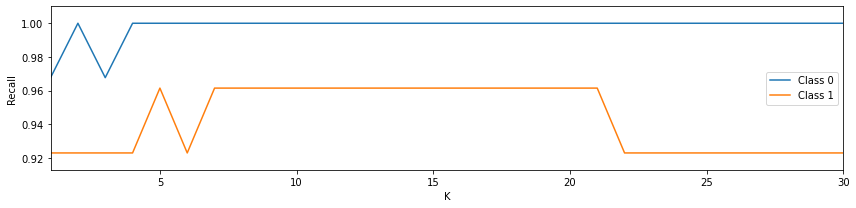

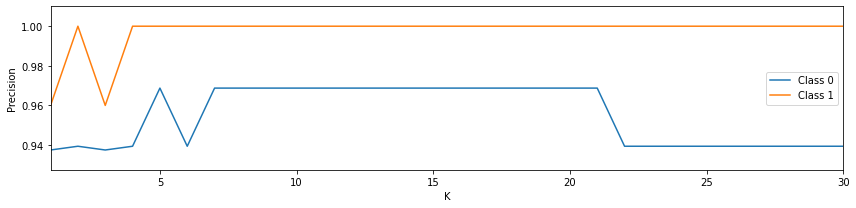

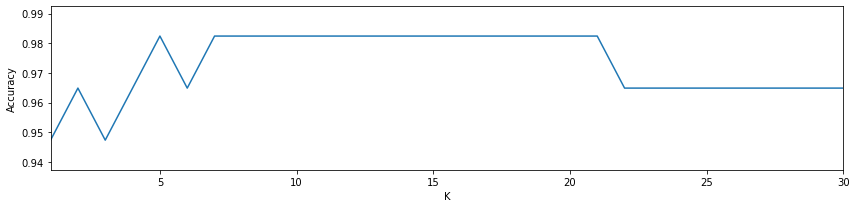

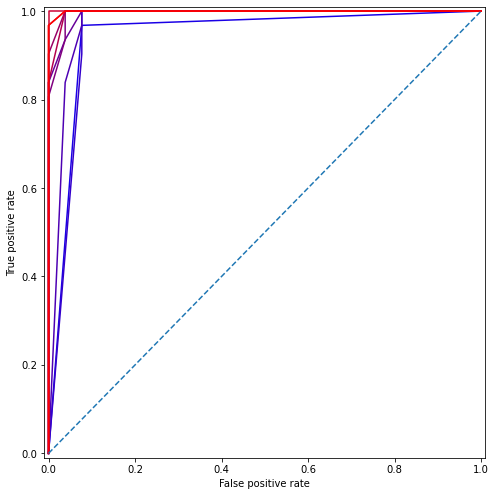

CPU times: user 6.32 s, sys: 76.1 ms, total: 6.39 s
Wall time: 6.52 s


In [12]:
%%time
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
X_train, X_test = normalize(X_train, X_test)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

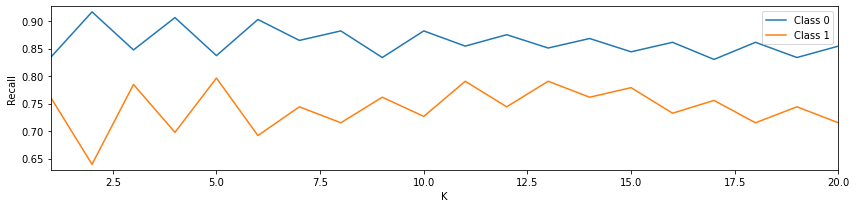

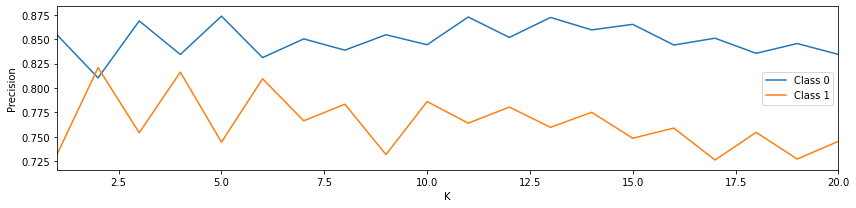

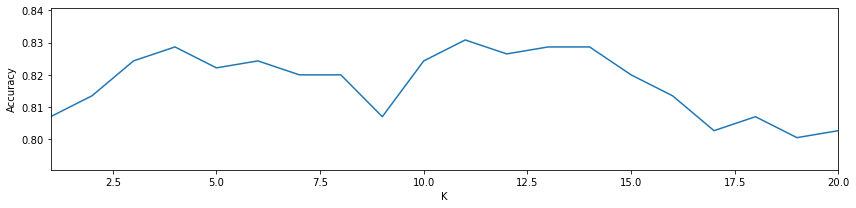

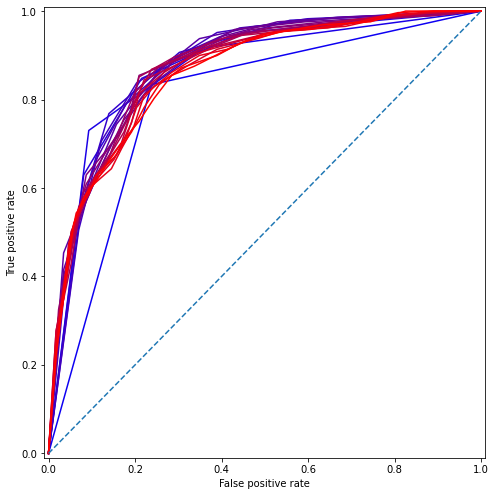

CPU times: user 3min 43s, sys: 495 ms, total: 3min 44s
Wall time: 3min 46s


In [14]:
%%time

X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
X_train, X_test = normalize(X_train, X_test)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)